## Receive Sensor Data from Phone (or other OSC app)

This notebook shows how to receive data from an OSC based application (such as [ZIG Simulator](https://zig-project.com)) to python, and export the data as CSV file that can be used as a dataset

In [ ]:
!conda install pandas -y
!pip install ipywidgets

In [17]:
import numpy as np
import io
import PML
import OSCHelper

features_names=['accel','gyro','miclevel']
labels=["Walking","Setting","Running","Waving"]

server=OSCHelper.createServer(50001)

samples=PML.CollectSamplesOSC(server,features_names,labels,UUID="Yamen",nPerLabel=1000)
PML.ExportOSCData(samples,features_names,"datasets/data.csv")
server.close()

Starting server on: 192.168.11.7:50001
Capturing samples for label: Walking
Press Enter to start...


IntProgress(value=0, max=1000)

done samples
Capturing samples for label: Setting
Press Enter to start...


IntProgress(value=0, max=1000)

done samples
Capturing samples for label: Running
Press Enter to start...


IntProgress(value=0, max=1000)

done samples
Capturing samples for label: Waving
Press Enter to start...


IntProgress(value=0, max=1000)

done samples
Total samples count: 4000
/Users/yamen/Documents/GitHub/PracticalML/4. Interactive ML/Python/datasets/data.csv


## Example of how to load CSV data
Here we will load the CSV file of data we just exported. This can be located in a different file

In [18]:
import PML

samples,labels=PML.load_csv_samples("datasets/data.csv")#load csv data file
print("Loaded Samples Count: {0}".format(len(samples)))
print("Features per Sample: {0}".format(len(samples[0][0])))
print("{0} --> {1}".format(labels[samples[0][1]],samples[0][0]))

Cols of data loaded:
['accel' 'gyro' 'miclevel' 'Label']
Loaded Samples Count: 4000
Features per Sample: 8
Walking --> [-0.038625240325927734, 0.32864105701446533, 0.4190443158149719, -0.43285396695137024, 0.19468314945697784, 1.2163407802581787, -120.0, -120.0]


/anaconda3/envs/PML/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/PML/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Prepare a Machine Learning Model

Here is how we simply can convert the data points to be used by the learning model

In [22]:

from tensorflow.keras import utils
import random
random.shuffle(samples)

X=[x[0] for x in samples]
Y=[x[1] for x in samples]
x_dataset,norm=PML.normalize_mean_std(X)

nb_classes=len(labels)
y_dataset = utils.to_categorical(Y, nb_classes)

In [23]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(x_dataset,y_dataset,test_size=0.1)

print("Training using: {0} samples".format(len(X_train)))
print("Validating using: {0} samples".format(len(X_test)))

Training using: 3600 samples
Validating using: 400 samples


Create the model, and start fitting it with the train data

In [84]:

model=PML.create_classify_model(X_train.shape[1],nb_classes,32,[16,8],dropout=0)
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=32)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 36        
Total params: 988
Trainable params: 988
Non-trainable params: 0
_________________________________________________________________
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 1s 169us/step - loss: 1.1340 - acc: 0.4872 - val_loss: 0.9316 - val_acc: 0.5725
Epoch 2/100
3600/3600 [==============================] - 0s 49us/step - loss: 0.7536 - acc: 

3600/3600 [==============================] - 0s 46us/step - loss: 0.0517 - acc: 0.9867 - val_loss: 0.1041 - val_acc: 0.9800
Epoch 55/100
3600/3600 [==============================] - 0s 47us/step - loss: 0.0503 - acc: 0.9881 - val_loss: 0.1071 - val_acc: 0.9825
Epoch 56/100
3600/3600 [==============================] - 0s 46us/step - loss: 0.0514 - acc: 0.9881 - val_loss: 0.1145 - val_acc: 0.9750
Epoch 57/100
3600/3600 [==============================] - 0s 48us/step - loss: 0.0488 - acc: 0.9881 - val_loss: 0.0986 - val_acc: 0.9850
Epoch 58/100
3600/3600 [==============================] - 0s 48us/step - loss: 0.0482 - acc: 0.9869 - val_loss: 0.1048 - val_acc: 0.9800
Epoch 59/100
3600/3600 [==============================] - 0s 51us/step - loss: 0.0485 - acc: 0.9872 - val_loss: 0.1131 - val_acc: 0.9775
Epoch 60/100
3600/3600 [==============================] - 0s 58us/step - loss: 0.0487 - acc: 0.9881 - val_loss: 0.0983 - val_acc: 0.9850
Epoch 61/100
3600/3600 [==============================

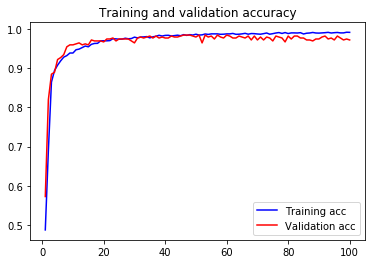

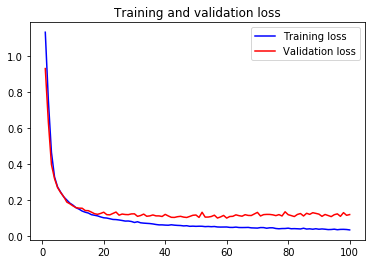

In [85]:
PML.plot_acc_loss(history)

In [ ]:
#setup OSC Protocol to communicate with Processing
import OSCHelper
from collections import deque #Deque is a Queue
from collections import Counter #This helps to count frequency of samples

server=OSCHelper.createServer(50003)
client=OSCHelper.createClient(4200)

features_names=['accel','gyro','miclevel']
sample=[]

WINDOW_SIZE=60
buffer=deque(maxlen=WINDOW_SIZE)

def reset_sample():
    global sample
    global features_names
    sample=[]
    for i in features_names:
        sample.append("")
        
def process_sample(x):
    sample=[]
    for i in range(len(x)):
        sample.extend(x[i].split(','))
    for i in range(len(sample)):
        sample[i]=float(sample[i])
        
    sample=norm.Normalize(sample)
    return sample
        
def onOSC_data(*args):
    global sample
    global features_names
    dtype=str(args[0]).split('/')[-1]
    vals=list(args[1:])
    index=-1
    for i,f in enumerate(features_names):
        if dtype==f:
            index=i
    if(index!=-1):
        sample[index]=','.join([str(x) for x in vals])

    if dtype=='deviceinfo':
        processed_sample=process_sample(sample)
        res=model.predict(np.array([processed_sample]))[0]
        index=np.argmax(res)
        result=(labels[index])
        
        buffer.append(result)
        freq=Counter(buffer)
        
        client.send_message("/output/label",[int(index),str(result)])
        reset_sample()


reset_sample()
        
server.addMsgHandler("/ZIGSIM/Yamen/*", onOSC_data )
OSCHelper.start_server(server)
server.removeMsgHandler("/ZIGSIM/Yamen/*")

In [94]:
server.close()